In [1]:
"hello"

'hello'

In [1]:
from fastai.imports import *

In [59]:
np.set_printoptions(linewidth=110)

In [3]:
import os
from pathlib import Path

In [4]:
path = Path('titanic')

In [6]:
path

Path('titanic')

In [7]:
!pip install kaggle

In [8]:
creds = '{"username":"antashmishra","key":"81a7de38221c6d0155c8d4c9cf8bfbdb"}'

In [9]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [10]:
if not path.exists():
  import zipfile, kaggle
  kaggle.api.competition_download_cli(str(path))
  zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 31.7MB/s]

In [11]:
df = pd.read_csv(path/'train.csv')

In [13]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
tst_df = pd.read_csv(path/'test.csv')

In [15]:
tst_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Preprocess data

In [18]:
# Preprocess data

modes = df.mode().iloc[0]

def proc_data(df):
  df['Fare'] = df.Fare.fillna(0)
  df.fillna(modes, inplace = True)
  df['LogFare'] = np.log1p(df.Fare)
  df['Embarked'] = pd.Categorical(df.Embarked)
  df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

In [22]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

In [19]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,2.202765


### Classifying different columns

In [28]:
cats = ['Sex', 'Embarked']
conts = ['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass']
dep = "Survived"

### Binary Splits

In [24]:
import seaborn as sns

[Text(0.5, 1.0, 'Histogram')]

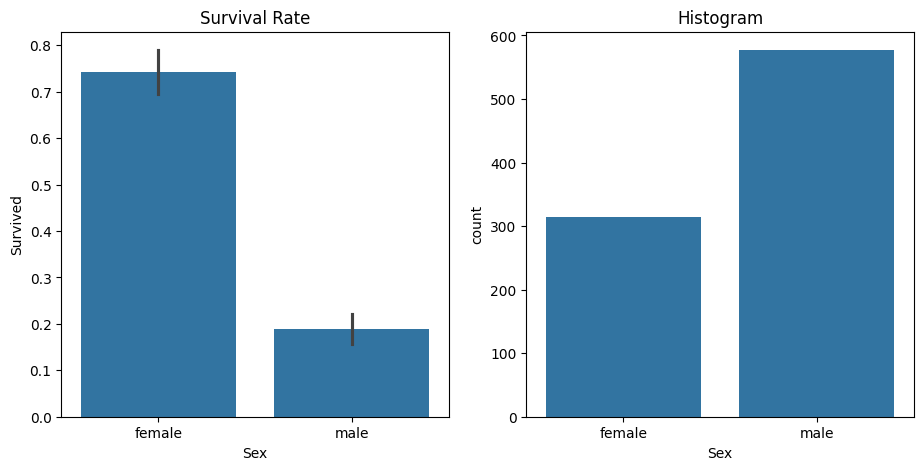

In [25]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df,x="Sex", y=dep, ax=axs[0]).set(title="Survival Rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram")

### Simplest Decision Tree (one variable)

In [26]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df, val_df = train_test_split(df, test_size=0.25)

# replacing cat variables with numbers
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [29]:
def xs_y(df):
  xs = df[cats+conts].copy()
  return xs, df[dep] if dep in df else None

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

In [30]:
preds = val_xs.Sex == 0
preds

709    False
439    False
840    False
720     True
39      True
       ...  
880     True
425    False
101    False
199     True
424    False
Name: Sex, Length: 223, dtype: bool

In [31]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(val_y, preds)

0.21524663677130046

<Axes: xlabel='LogFare', ylabel='Density'>

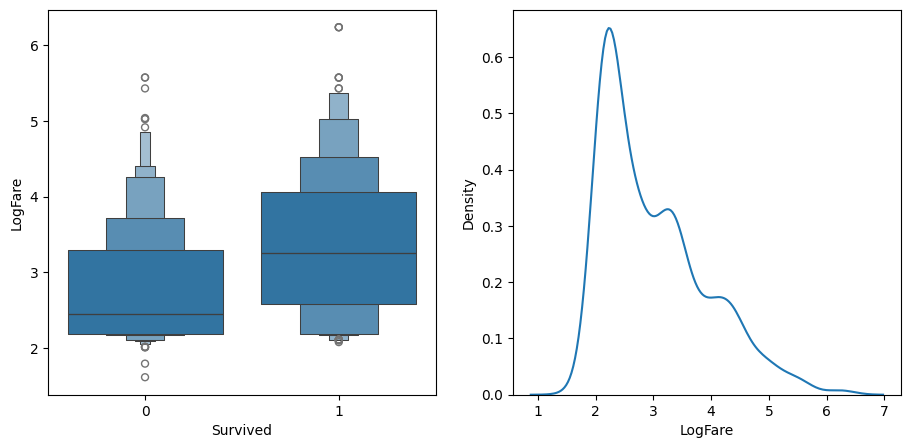

In [32]:
df_fare= trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y = "LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax = axs[1])

In [33]:
preds = val_xs.LogFare>2.7

In [34]:
mean_absolute_error(val_y, preds)

0.336322869955157

### Calculating Impurity

In [35]:
def _side_score(side, y):
  tot = side.sum()
  if tot<=1: return 0
  return y[side].std()*tot

In [36]:
def score(col, y, split):
  lhs = col <= split
  return (_side_score(lhs, y) + _side_score(~lhs, y))/len(y)

In [37]:
score(trn_xs['Sex'], trn_y, 0.5)

0.40787530982063946

In [38]:
score(trn_xs['LogFare'], trn_y, 2.7)

0.47180873952099694

In [39]:
def iscore(nm, split):
  col = trn_xs[nm]
  return score(col, trn_y, split)

from ipywidgets import interact

interact(nm= conts, split=15.5)(iscore)

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

<function __main__.iscore(nm, split)>

### Finding Best Split

In [40]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [41]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

6.0

In [42]:
# Defining above method

def min_col(df, nm):
  col, y = df[nm], df[dep]
  unq = col.unique()
  scores = np.array([score(col, y, o) for o in unq if not np.isnan(0)])
  idx = scores.argmin()
  return unq[idx], scores[idx]

min_col(trn_df, "Age")

(6.0, 0.478316717508991)

In [44]:
cols = cats + conts

{col: min_col(trn_df, col) for col in cols}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

### Decision Tree (With multiple layers)

In [45]:
cols.remove('Sex')
ismale = trn_df.Sex == 1
males, females= trn_df[ismale], trn_df[~ismale]

In [46]:
# Impurity for male
{o: min_col(males, o) for o in cols}

{'Embarked': (0, 0.3875581870410906),
 'Age': (6.0, 0.3739828371010595),
 'SibSp': (4, 0.3875864227586273),
 'Parch': (0, 0.3874704821461959),
 'LogFare': (2.803360380906535, 0.3804856231758151),
 'Pclass': (1, 0.38155442004360934)}

In [47]:
# Impurity for female
{o: min_col(females, o) for o in cols}

{'Embarked': (0, 0.4295252982857327),
 'Age': (50.0, 0.4225927658431649),
 'SibSp': (4, 0.42319212059713535),
 'Parch': (3, 0.4193314500446158),
 'LogFare': (4.256321678298823, 0.41350598332911376),
 'Pclass': (2, 0.3335388911567601)}

In [48]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

model = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y)

In [49]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
  s = export_graphviz(t, out_file=None, feature_names = df.columns,
                      filled=True, rounded=True, special_characters=True, rotate=False, precision=precision, **kwargs)
  return graphviz.Source(re.sub('Tree {', f'Tree {{ size = {size}; rato={ratio}',s))

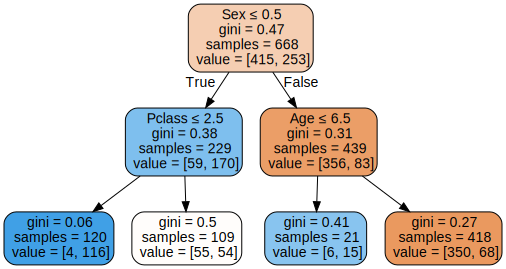

In [50]:
draw_tree(model, trn_xs, size=10)

In [53]:
def gini(cond):
  act = df.loc[cond, dep]
  return 1- act.mean()**2 - (1-act).mean()**2

In [55]:
gini(df.Sex == 'female'), gini(df.Sex == 'male')

(0.3828350034484158, 0.3064437162277842)

In [56]:
mean_absolute_error(val_y, model.predict(val_xs))

0.2242152466367713

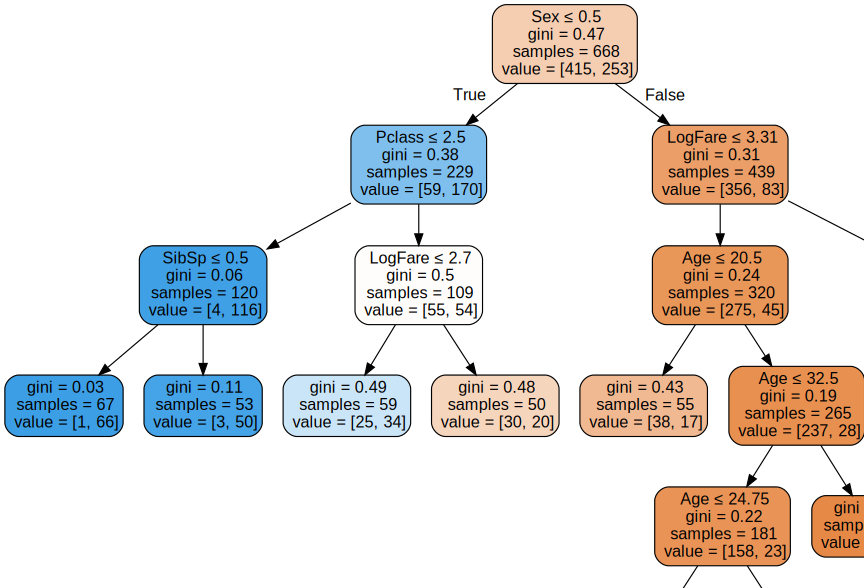

In [60]:
model = DecisionTreeClassifier(min_samples_leaf=50)
model.fit(trn_xs, trn_y)
draw_tree(model, trn_xs, size=12)

In [61]:
mean_absolute_error(val_y, model.predict(val_xs))

0.18385650224215247

### Random Forest

#### Decison Tree with Bagging

In [62]:
def get_tree(prop=0.75):
  n=len(trn_y)
  idxs = random.choice(n, int(n*prop))
  return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [63]:
trees = [get_tree() for t in range(100)]

In [64]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)
mean_absolute_error(val_y, avg_probs)

0.22735426008968612

#### **Real** Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y)
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

<Axes: ylabel='cols'>

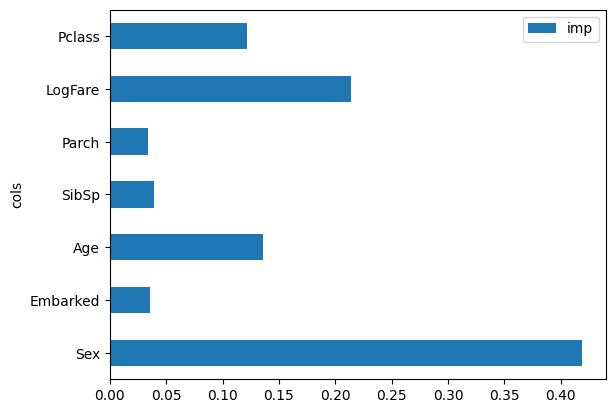

In [69]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh')